In [1]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statistics import mean, stdev
from tqdm import tqdm
from itertools import product

# Problem

Given $n$ unique objects, each with a sampling probability of $\frac{1}{n}$,
how many trials do we need on average to collect all $n$ objects?

This is known as the [Coupon collector's problem](https://en.wikipedia.org/wiki/Coupon_collector%27s_problem).

## Empirical

In [2]:
def trial(n):
    count = 0
    s = set()
    while len(s) != n:
        s.add(random.randint(1,n))
        count += 1
    return count

def compute_statistics(data):
    mu = mean(data)
    sigma = stdev(data, xbar=mu)
    return mu, sigma

In [3]:
max_n = 10
ntrials = 100000
data = []

pbar = tqdm(total=ntrials*max_n, ncols=100)
for n in range(1, max_n+1):
    counts = []
    for _ in range(ntrials):
        counts.append(trial(n))
        pbar.update(1)
    data.append(compute_statistics(counts))
pbar.close()

100%|██████████████████████████████████████████████████| 1000000/1000000 [00:13<00:00, 76741.16it/s]


In [4]:
empirical = pd.DataFrame(data, columns=['mean', 'std. dev.'], index=np.arange(1, max_n+1))
empirical

,mean,std. dev.
1,1.00000,0.000000
2,3.00298,1.418630
3,5.50838,2.614303
4,8.32114,3.798570
5,11.40073,4.984911
6,14.71420,6.261504
7,18.14309,7.475562
8,21.70661,8.695803
9,25.51768,9.998824
10,29.27614,11.236035


## Theory

If $n=2$, then we will get an item on the first trial, and getting the second item will take 2 trials in expectation. So a total of 3 trials in expectation.


If $n=3$, then again one item on the first trial, then $2/3$ chance to get a different item from then on, for an expected number of $3/2=1.5$ items. Once we have a second item, we have a $1/3$ of getting the third, which requires $3$ trials in expectation. So a total of $1+3/2+3 = 11/2 = 5.5$ trials in expectaion.

In general, let $X^n$ be a random variable that represents the number of trials needed to complete a collection with $n$ items. Then the expected value is given by
$$ \mathbb{E}(X^n) = \sum_{k=1}^n \frac{n}{k} = nH_n $$
where $H_n$ is the $n$-th [Harmonic number](https://mathworld.wolfram.com/HarmonicNumber.html). 

It doesn't seem like there is a closed form for $H_n$, since it is given by
$$ H_n = \gamma + \psi_0(n+1)$$
where $\gamma\approx0.557$ is the [Euler-Mascheroni constant](https://mathworld.wolfram.com/Euler-MascheroniConstant.html)
and $\psi_0(x)$ is the [digamma function](https://mathworld.wolfram.com/DigammaFunction.html). Note that $\gamma$ is itself defined in terms of limits with $H_n$ terms, namely 
$$\gamma = \lim_{n\rightarrow\infty}(H_n - \ln n)$$

However, we can write $\mathbb{E}(X^n)$ as a recursive formula to facilitate computation:
$$\mathbb{E}(X^{n+1}) = \frac{n+1}{n}\mathbb{E}(X^n) + 1$$
where clearly $\mathbb{E}(X^0) = 1$.

We can verify our derivation using the empirical results above

In [5]:
def expectation(n):
    Hn = sum((1/k for k in range(1,n+1)))
    return n * Hn

def expectation_list(max_n):
    E_Xn = [1]
    for n in range(2, max_n+1):
        E_Xn.append(E_Xn[-1]*n/(n-1) + 1)
    return E_Xn

In [6]:
data = expectation_list(10)

In [7]:
compare = pd.DataFrame({
    'Theory': data,
    'Empirical': empirical['mean']
}, index=np.arange(1, max_n+1))
compare['abs. diff.'] = (compare.iloc[:,0] - compare.iloc[:,1]).abs()
compare['rel. diff.'] = compare['abs. diff.'] / compare['Theory']
compare

,Theory,Empirical,abs. diff.,rel. diff.
1,1.000000,1.00000,0.000000,0.000000
2,3.000000,3.00298,0.002980,0.000993
3,5.500000,5.50838,0.008380,0.001524
4,8.333333,8.32114,0.012193,0.001463
5,11.416667,11.40073,0.015937,0.001396
6,14.700000,14.71420,0.014200,0.000966
7,18.150000,18.14309,0.006910,0.000381
8,21.742857,21.70661,0.036247,0.001667
9,25.460714,25.51768,0.056966,0.002237
10,29.289683,29.27614,0.013543,0.000462


Particularly useful is the quantity 
$$\frac{\mathbb{E}(X^n)}{n} = \frac{n H_n}{n} = H_n$$ 
denoting how many times more trials are needed (in expectation) to collect all $n$ items. Since the harmonic series diverges, this ratio is unbounded.

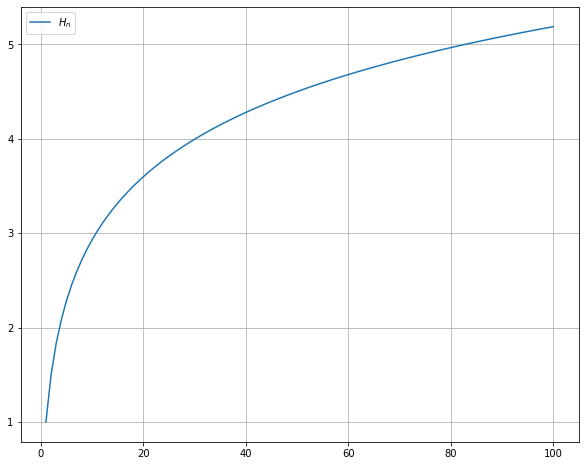

In [8]:
max_n = 100
E_Xn = np.array(expectation_list(max_n))
ns = np.arange(1, max_n+1)
Hns = E_Xn / ns

plt.figure(figsize=(10,8));
plt.plot(ns, Hns, label='$H_n$');
plt.legend();
plt.grid('both');

## Asymptotically

We have the following asymptotic behavior for $H_n$
$$ H_n \sim \ln n + \gamma + \frac{1}{2n} + O\left(\frac{1}{n^2}\right)$$
and therefore
$$ \mathbb{E}(X^n) \sim n\ln n + n\gamma + \frac{1}{2}$$
We also consider the much rougher, but easier to remember, approximation:
$$ \mathbb{E}(X^n) \sim n\ln n + \frac{n}{2}$$

In [9]:
max_n = 100

# Exact expectation
E_Xn = expectation_list(max_n)

# Approximations
gamma = 0.57721566490153286060651209
ns = np.arange(1, max_n+1)
f1 = ns * np.log(ns) + ns * gamma + 1/2
f2 = ns * np.log(ns) + ns / 2

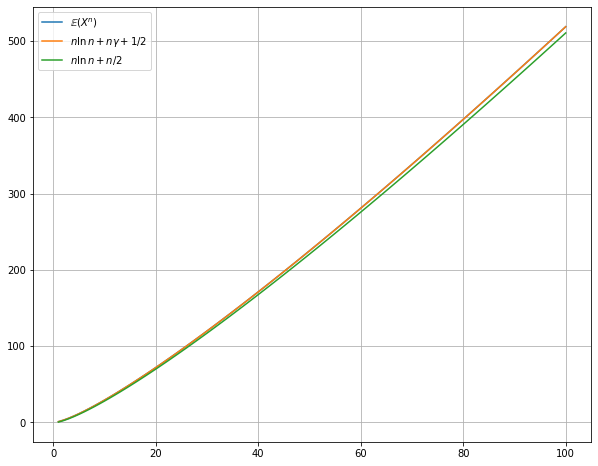

In [10]:
plt.figure(figsize=(10,8));
plt.plot(ns, E_Xn, label='$\mathbb{E}(X^n)$');
plt.plot(ns, f1, label='$n\ln n + n\gamma + 1/2$');
plt.plot(ns, f2, label='$n\ln n + n/2$');
plt.legend();
plt.grid('both');
# plt.yscale('log');

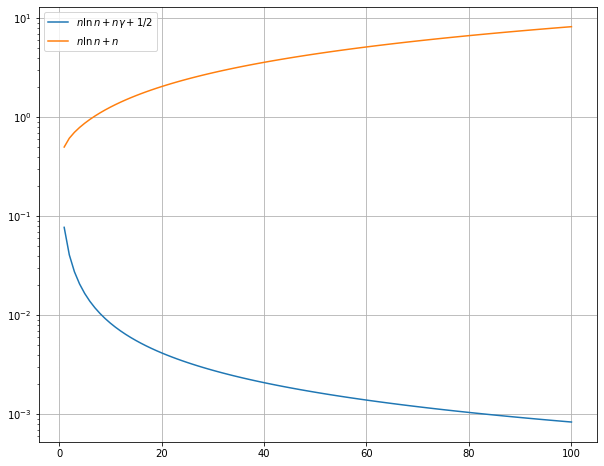

In [11]:
plt.figure(figsize=(10,8));
plt.plot(ns, np.abs(f1 - E_Xn), label='$n\ln n + n\gamma + 1/2$');
plt.plot(ns, np.abs(f2 - E_Xn), label='$n\ln n + n$');
plt.legend();
plt.grid('both');
plt.yscale('log');